#Laboratorio 8 modelo de clasificacion de caracteres alfabeticos (EMNIST)
##Participantes del grupo 1:

> Wilson Macias Valencia, **Carrera:** Ing. Sitemas


> Taboada Chuve Alexy Sdenka **Carrera:** Ing. Ciencias de la computación 


> Vidaurre Mejia Lesly Tania **Carrera:** Ing. Ciencias de la computación


> Olpo Vilca Jose Antonio **Carrera:** Ing. Diseño y animación digital 



> Limachi Carrillo Grover Carrera: Ing. Ciencias de la computación 























In [ ]:
#Librerias
import torch 
import torchvision
import matplotlib as plt
import numpy as np

In [ ]:
#Descargar el EMNIST
trainset = torchvision.datasets.EMNIST(root='./data', split = "letters" ,train=True, download=True)
testset = torchvision.datasets.EMNIST(root='./data', split = "letters",train = False, download = True)

In [ ]:
#Identificar las clases 
clases = ('a','b','c','d','e','f','g','h','i','j','k','l','m','n','o','p','q','r','s','t','u','v','w','x','y','z')
len(clases)
len(trainset), len(testset) # Mostrar el tamaño de los datos del dataset de entrenamiento y de prueba

(124800, 20800)

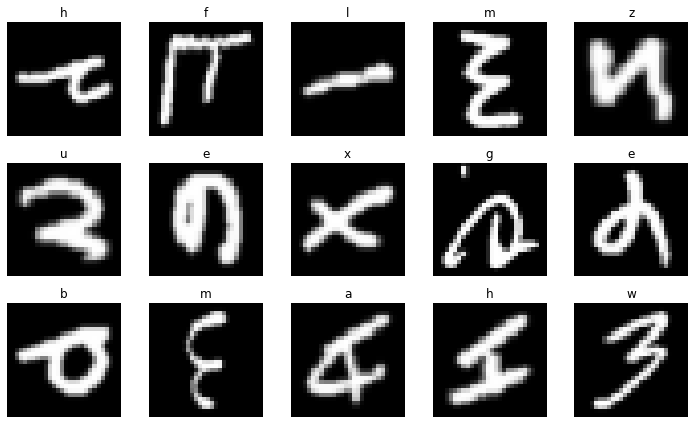

In [ ]:
#Visualizacion de imágenes 
import random
import matplotlib.pyplot as plt

r, c = 3, 5
fig = plt.figure(figsize=(2*c, 2*r))
for _r in range(r):
    for _c in range(c):
        ax = plt.subplot(r, c, _r*c + _c + 1 )
        ix = random.randint(0, len(trainset))
        img, label = trainset[ix]
        plt.axis("off")
        plt.imshow(img, cmap = 'gray')
        plt.title(clases[label-1])
plt.tight_layout()
plt.show()

In [ ]:
# convertimos imágenes a arrays de numpy

import numpy as np

train_images = np.array([np.array(img) for img, label in trainset])
test_images = np.array([np.array(img) for img, label in testset])

train_labels = np.array([label for img, label in trainset])
test_labels = np.array([label for img, label in testset])

In [ ]:
# ver número de imágenes, resolución y número de canales

train_images.shape, test_images.shape, train_labels.shape, test_labels.shape

((124800, 28, 28), (20800, 28, 28), (124800,), (20800,))

In [ ]:
# tipo de datos

train_images.dtype, train_labels.dtype

(dtype('uint8'), dtype('int64'))

In [ ]:
# estadísiticos

max_value = train_images.max(axis=(0, 1, 2))
min_value = train_images.min(axis=(0, 1, 2))

max_value, min_value

(255, 0)

In [ ]:
mean = (train_images / 255).mean(axis=(0, 1, 2))
std = (train_images / 255).std(axis=(0, 1, 2))

mean, std

(0.1722273037019294, 0.3309466273149429)

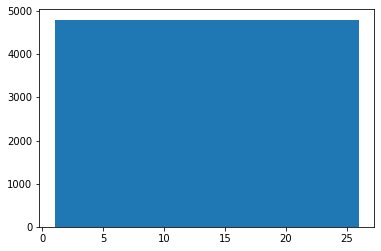

In [ ]:
# distribución de clases

plt.hist(train_labels, bins=len(clases))
plt.show()

In [ ]:
unique, counts = np.unique(train_labels, return_counts=True)
unique, counts

(array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26]),
 array([4800, 4800, 4800, 4800, 4800, 4800, 4800, 4800, 4800, 4800, 4800,
        4800, 4800, 4800, 4800, 4800, 4800, 4800, 4800, 4800, 4800, 4800,
        4800, 4800, 4800, 4800]))

En este caso nuestro dataset está balanceado (tenemos el mismo número de muestras por cada clase). En ocasiones, éste no será el caso. Entrenar un modelo con un dataset desbalanceado introducirá bias, haciendo que nuestro modelo sea más propenso a predecir las clases más presentes. Para solventar este problema existen varias opciones, la más común es sobre-muestrear las clases menos representadas (combinado con data augmentation puede ser especialmente positivo).

Una vez conocemos bien nuestros datos, podemos empezar a trabajar en nuestra red neuronal. Sin embargo, antes de entrenarla en todo nuestro dataset será muy positivo seguir antes los siguiente pasos.

# Validando nuestra red neuronal




In [ ]:
#Validando nuestra red neuronal
import torch

def build_model(D_in=28*28, H=100, D_out=27):
    return torch.nn.Sequential(
        torch.nn.Linear(D_in, H),
        torch.nn.ReLU(),
        torch.nn.Linear(H, H),
        torch.nn.ReLU(),
        torch.nn.Linear(H, D_out)
    )

Una muy buena manera de asegurarnos que nuestra red hace lo que debería es pasarle como entrada un tensor con las dimensiones esperadas durante el entrenamiento y asegurarnos que la salida que nos da coincide también con lo que esperamos. En nuestro caso, enviaremos tensores que contendrán un número determinado de imágenes (un batch, por ejemplo 64) y cada imagen estará representada por un vector de  28*28 valores. La salida debería ser un vector de 27 valores para cada imagen del batch representando la probabilidad de cada clase.

In [ ]:
model = build_model()
test_input = torch.randn((64, 28*28))
test_output = model(test_input)
test_output.shape

torch.Size([64, 27])

Si cometemos algún error definiendo nuestra red neuronal, en este paso lo podríamos detectar. 

# Fit de una muestra

Una vez nos hemos asegurado que las dimensiones de nuestra red están bien, el siguiente paso es asegurarnos de que es capaz de aprenderse de memoria una sola muestra del dataset. Si este no es el caso podemos estar seguros de que algo no anda bien.

In [ ]:
import numpy as np

train_images = np.array([np.array(img) for img, label in trainset])
X_test = np.array([np.array(img) for img, label in testset])

train_labels = np.array([label for img, label in trainset])
y_test = np.array([label for img, label in testset])

X_train, X_val, X_subset = train_images[:40000], train_images[40000:], train_images[:5000]
y_train, y_val, y_subset = train_labels[:40000], train_labels[40000:], train_labels[:5000]

X_train.shape, X_val.shape, X_test.shape, X_subset.shape

((40000, 28, 28), (84800, 28, 28), (20800, 28, 28), (5000, 28, 28))

In [ ]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, X, Y):
        self.X = torch.from_numpy(X / 255.).float().view(-1, 28*28)
        self.Y = torch.from_numpy(Y).long()
    def __len__(self):
        return len(self.X)
    def __getitem__(self, ix):
        return self.X[ix], self.Y[ix]

In [ ]:
# fit de la primera imagen del dataset 

dataset = Dataset(X_subset[:1], y_subset[:1])
dataloader = torch.utils.data.DataLoader(dataset, batch_size=1)

len(dataset)

1

In [ ]:
epochs = 3
criterion = torch.nn.CrossEntropyLoss()
model = build_model()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
for e in range(1, epochs+1): 
    for x_b, y_b in dataloader:
        y_pred = model(x_b)
        loss = criterion(y_pred, y_b)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        print(f"Epoch {e}/{epochs} loss {loss.item():.5f} y {y_b.item()} y_pred {torch.argmax(y_pred, axis=1).item()}")

Epoch 1/3 loss 3.33198 y 23 y_pred 13
Epoch 2/3 loss 1.16341 y 23 y_pred 23
Epoch 3/3 loss 0.00767 y 23 y_pred 23


Podemos hacer el fit de una imagen sin problema. Errores como una función de pérdida incorrecta o diferentes dimensiones entre las predicciones y las etiquetas podrían ser detectados en este paso.

## Fit de un batch

Siguiendo la misma lógica, nuestro modelo debería ser capaz de aprenderse de memoria un solo batch de imágenes.

In [ ]:
# fit de un batch

dataset = Dataset(X_subset[:64], y_subset[:64])
dataloader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=True)

len(dataset)

64

In [ ]:
epochs = 100
criterion = torch.nn.CrossEntropyLoss()
model = build_model()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
for e in range(1, epochs+1): 
    for x_b, y_b in dataloader:
        y_pred = model(x_b)
        loss = criterion(y_pred, y_b)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        acc = (y_b == torch.argmax(y_pred, axis=1)).sum().item()  
        if not e % 10:
            print(f"Epoch {e}/{epochs} loss {loss.item():.5f} acc {acc}/{y_b.shape[0]}")

Epoch 10/100 loss 0.19199 acc 63/64
Epoch 20/100 loss 0.00050 acc 64/64
Epoch 30/100 loss 0.00008 acc 64/64
Epoch 40/100 loss 0.00001 acc 64/64
Epoch 50/100 loss 0.00001 acc 64/64
Epoch 60/100 loss 0.00000 acc 64/64
Epoch 70/100 loss 0.00000 acc 64/64
Epoch 80/100 loss 0.00000 acc 64/64
Epoch 90/100 loss 0.00000 acc 64/64
Epoch 100/100 loss 0.00000 acc 64/64


En este punto ya podemos estar bastante seguros de que nuestro modelo está bien definido, estamos usando la función de pérdida y optimizador adecuados, nuestro bucle de entrenamiento funciona bien, etc.

## Entrenando con un sub-conjunto de datos

Entrenar una red neuronal en un dataset completo puede ser computacionalmente costoso si el dataset es muy grande. Esto implica que si queremos hacer pruebas para probar diferentes combinaciones de hyperparámetros vamos a tener que esperar mucho tiempo, o alquilar grandes clusters de GPUs (lo cual es muy caro). Una solución es iterar utilizando un sub-conjunto representativo de nuestro dataset, confiando en que las conclusiones a las que lleguemos en este pequeño conjunto luego se transfieran a todo el dataset.

In [ ]:
dataset = {
    'train': Dataset(X_subset, y_subset),
    'val': Dataset(X_val, y_val),
}

dataloader = {
    'train': torch.utils.data.DataLoader(dataset['train'], batch_size=32, shuffle=True),
    'val': torch.utils.data.DataLoader(dataset['val'], batch_size=1000, shuffle=False)
}

len(dataset['train']), len(dataset['val'])

(5000, 84800)

In [ ]:
from sklearn.metrics import accuracy_score

def softmax(x):
    return torch.exp(x) / torch.exp(x).sum(axis=-1,keepdims=True)

def fit(model, dataloader, optimizer, scheduler=None, epochs=10, log_each=1, weight_decay=0, early_stopping=0, verbose=1):
    criterion = torch.nn.CrossEntropyLoss()
    l, acc, lr = [], [], []
    val_l, val_acc = [], []
    best_acc, step = 0, 0
    for e in range(1, epochs+1): 
        _l, _acc = [], []
        for param_group in optimizer.param_groups:
            lr.append(param_group['lr'])
        model.train()
        for x_b, y_b in dataloader['train']:
            y_pred = model(x_b)
            loss = criterion(y_pred, y_b)
            _l.append(loss.item())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            y_probas = torch.argmax(softmax(y_pred), axis=1)            
            _acc.append(accuracy_score(y_b.cpu().numpy(), y_probas.cpu().detach().numpy()))
        l.append(np.mean(_l))
        acc.append(np.mean(_acc))
        model.eval()
        _l, _acc = [], []
        with torch.no_grad():
            for x_b, y_b in dataloader['val']:
                y_pred = model(x_b)
                loss = criterion(y_pred, y_b)
                _l.append(loss.item())
                y_probas = torch.argmax(softmax(y_pred), axis=1)            
                _acc.append(accuracy_score(y_b.cpu().numpy(), y_probas.cpu().numpy()))
        val_l.append(np.mean(_l))
        val_acc.append(np.mean(_acc))
        # guardar mejor modelo
        if val_acc[-1] > best_acc:
            best_acc = val_acc[-1]
            torch.save(model.state_dict(), 'ckpt.pt')
            step = 0
            if verbose == 2:
                print(f"Mejor modelo guardado con acc {best_acc:.5f} en epoch {e}")
        step += 1
        if scheduler:
            scheduler.step()
        # parar
        if early_stopping and step > early_stopping:
            print(f"Entrenamiento detenido en epoch {e} por no mejorar en {early_stopping} epochs seguidas")
            break
        if not e % log_each and verbose:
            print(f"Epoch {e}/{epochs} loss {l[-1]:.5f} acc {acc[-1]:.5f} val_loss {val_l[-1]:.5f} val_acc {val_acc[-1]:.5f} lr {lr[-1]:.5f}")
    # cargar mejor modelo
    model.load_state_dict(torch.load('ckpt.pt'))
    return {'epoch': list(range(1, len(l)+1)), 'loss': l, 'acc': acc, 'val_loss': val_l, 'val_acc': val_acc, 'lr': lr}

Por ejemplo, de la siguiente manera podríamos elegir un learning rate adecuado.

In [ ]:
lrs = [0.01, 0.001, 0.0001]
hists = []
for lr in lrs:
    print(f"Probando lr {lr}")
    model = build_model()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    hist = fit(model, dataloader, optimizer, epochs=10, verbose=0)
    hists.append(hist)

Probando lr 0.01
Probando lr 0.001
Probando lr 0.0001


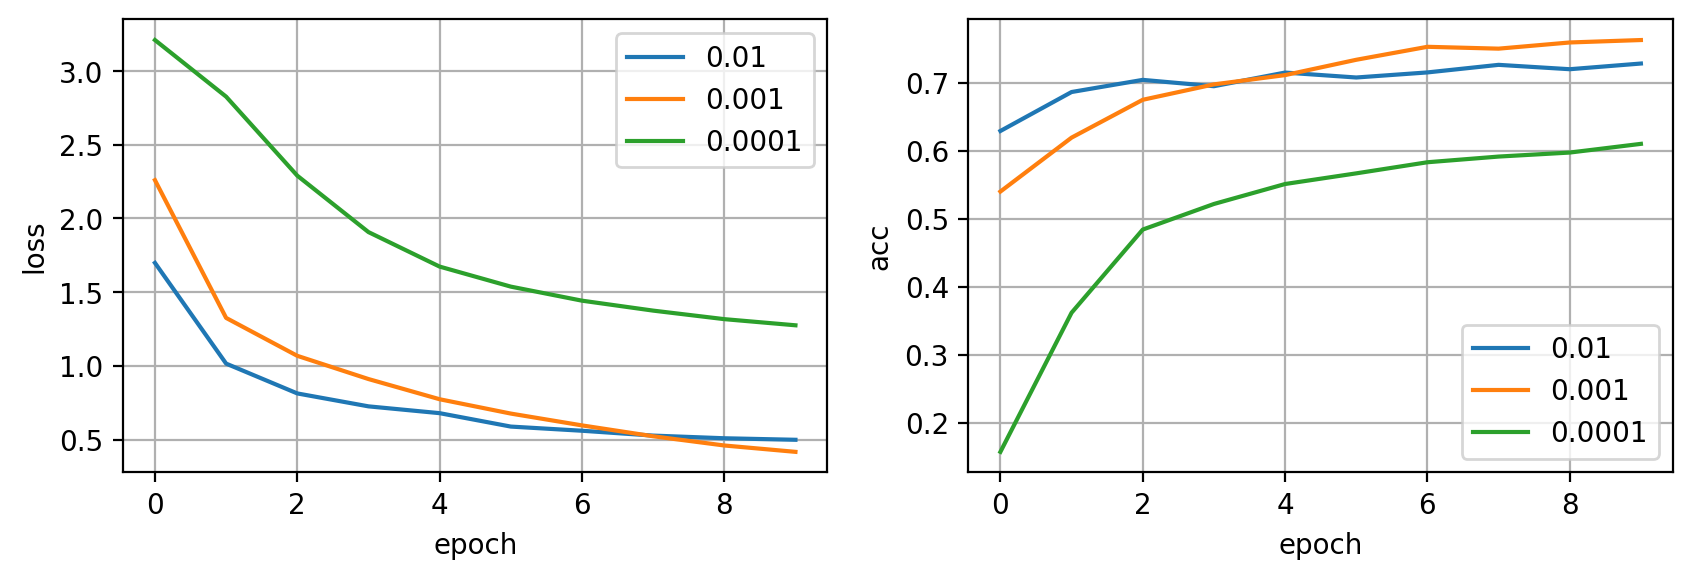

In [ ]:
fig = plt.figure(dpi=200, figsize=(10,3))
ax = plt.subplot(121)
for i in range(len(lrs)):
    ax.plot(hists[i]['loss'], label=lrs[i])
ax.legend()
ax.grid(True)
ax.set_xlabel('epoch')
ax.set_ylabel('loss')
ax = plt.subplot(122)
for i in range(len(lrs)):
    ax.plot(hists[i]['val_acc'], label=lrs[i])
ax.legend()
ax.grid(True)
ax.set_ylabel('acc')
ax.set_xlabel('epoch')
plt.show()

Parece que el valor intermedio de 0.001 nos da los mejores resultados en este caso. Ahora repetimos el experimento con todos los datos.

In [ ]:
dataset = {
    'train': Dataset(X_train, y_train),
    'val': Dataset(X_val, y_val),
}

dataloader = {
    'train': torch.utils.data.DataLoader(dataset['train'], batch_size=32, shuffle=True),
    'val': torch.utils.data.DataLoader(dataset['val'], batch_size=1000, shuffle=False)
}

len(dataset['train']), len(dataset['val'])

(40000, 84800)

## Configuraciones recomendadas

## Batch Size

Valores recomendados son: 16, 32, 64. Puedes empezar por estos valores y luego experimentar con otros. Aún así, la tendencia es intentar utilizar el batch size más grande posible que quepa en la memoria de la GPU (o GPUs) y adaptar el learning rate para obtener un buen entrenamiento.

In [ ]:
bss = [16, 32, 64]
hists = []
for bs in bss:
    print(f"Probando bs {bs}")
    dataloader = {
        'train': torch.utils.data.DataLoader(dataset['train'], batch_size=bs, shuffle=True),
        'val': torch.utils.data.DataLoader(dataset['val'], batch_size=1000, shuffle=False)
    }
    model = build_model()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    hist = fit(model, dataloader, optimizer, epochs=10, verbose=0)
    hists.append(hist)

Probando bs 16
Probando bs 32
Probando bs 64


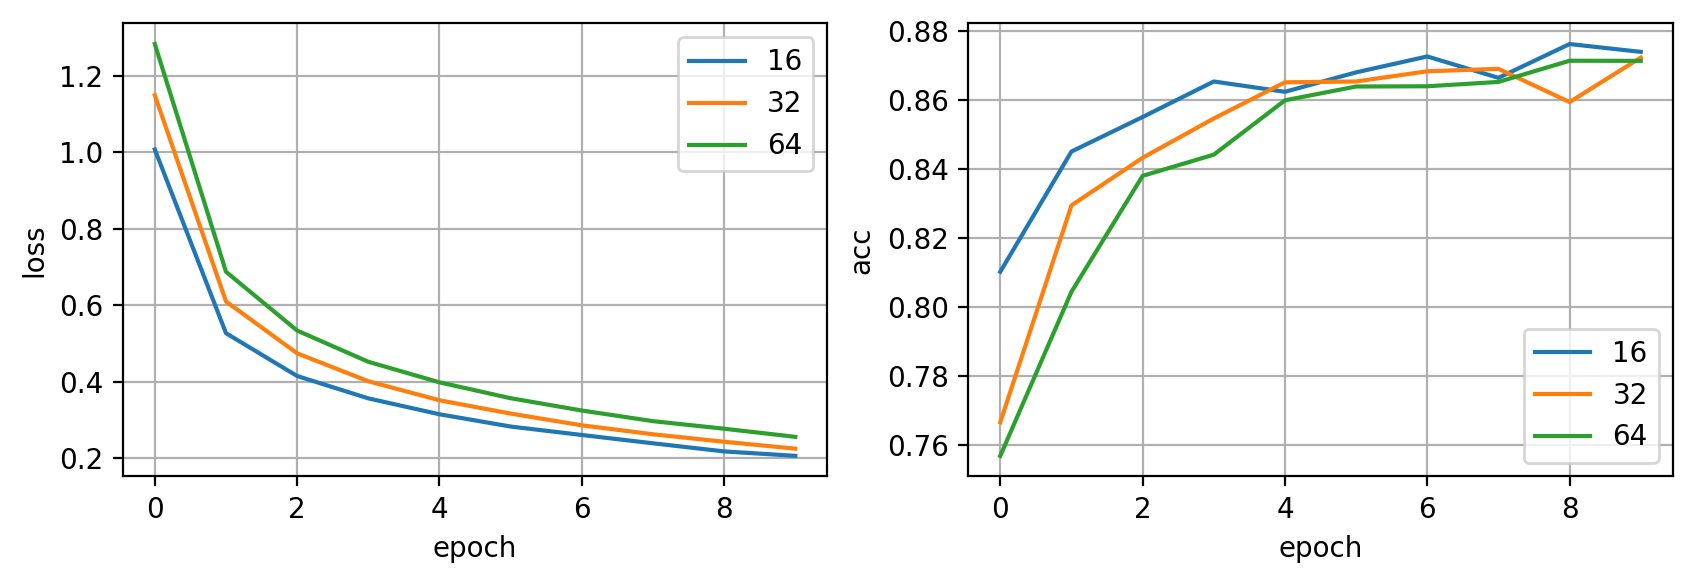

In [ ]:
fig = plt.figure(dpi=200, figsize=(10,3))
ax = plt.subplot(121)
for i in range(len(bss)):
    ax.plot(hists[i]['loss'], label=bss[i])
ax.legend()
ax.grid(True)
ax.set_xlabel('epoch')
ax.set_ylabel('loss')
ax = plt.subplot(122)
for i in range(len(bss)):
    ax.plot(hists[i]['val_acc'], label=bss[i])
ax.legend()
ax.grid(True)
ax.set_ylabel('acc')
ax.set_xlabel('epoch')
plt.show()

Obtenemos el mismo resultado, pero necesitando mucho más tiempo y cálculo. Así pues, experimentar rápidamente en un subconjunto representativo nos puede dar una gran ventaja.

## Optimizador y learning rate

Un buena combinación inicial es el optimizador Adam con un learning rate de  0.001 . A partir de aquí puede experimentar con otros valores para sacar un extra de performance, pero estos valores suelen ser buenos para empezar.

## Regularización

Cuando trabajamos con imágenes, utilizar data augmentation y batch norm es muy aconsejable para obtener buenos resultados. Combinándolo con early stopping seremos capaces de maneter el overfitting a raya. Puedes usar Weight decay si utilizas el optimizador SGD para regularizar mnás tu modelo, e incluso probar Dropout (sobretodo en arquitecturas de tipo MLP, no tanto en redes convolucionales).

In [ ]:
def build_model(D_in=28*28, H=100, D_out=27):
    return torch.nn.Sequential(
        torch.nn.Linear(D_in, H),
        torch.nn.BatchNorm1d(H),
        torch.nn.ReLU(),
        torch.nn.Linear(H, H),
        torch.nn.BatchNorm1d(H),
        torch.nn.ReLU(),
        torch.nn.Linear(H, D_out)
    )

In [ ]:
from albumentations import Compose, RandomCrop, Resize, HorizontalFlip, ToGray, RGBShift, OneOf

trans = Compose([
    RandomCrop(24,24),
    Resize(28, 28),
    HorizontalFlip()
 
])

class Dataset(torch.utils.data.Dataset):
    def __init__(self, X, Y, trans=None):
        self.X = X
        self.Y = Y
        self.trans = trans
    def __len__(self):
        return len(self.X)
    def __getitem__(self, ix):
        img = self.X[ix]
        if self.trans:
            img = trans(image=img)["image"]
        img = torch.from_numpy(img / 255.).float().view(-1)
        label = torch.tensor(self.Y[ix]).long()
        return img, label

dataset = {
    'train': Dataset(X_subset, y_subset, trans=trans),
    'val': Dataset(X_val, y_val),
}

dataloader = {
    'train': torch.utils.data.DataLoader(dataset['train'], batch_size=64, shuffle=True),
    'val': torch.utils.data.DataLoader(dataset['val'], batch_size=1000, shuffle=False)
}

len(dataset['train']), len(dataset['val'])

(5000, 84800)

In [ ]:
model = build_model()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
hist = fit(model, dataloader, optimizer, epochs=100, early_stopping=10, verbose=2)





Mejor modelo guardado con acc 0.32334 en epoch 1
Epoch 1/100 loss 2.62202 acc 0.27769 val_loss 2.41181 val_acc 0.32334 lr 0.00100
Mejor modelo guardado con acc 0.41311 en epoch 2
Epoch 2/100 loss 2.03346 acc 0.42069 val_loss 2.09053 val_acc 0.41311 lr 0.00100
Mejor modelo guardado con acc 0.46027 en epoch 3
Epoch 3/100 loss 1.75881 acc 0.48873 val_loss 1.87003 val_acc 0.46027 lr 0.00100
Mejor modelo guardado con acc 0.47291 en epoch 4
Epoch 4/100 loss 1.57514 acc 0.53995 val_loss 1.81775 val_acc 0.47291 lr 0.00100
Mejor modelo guardado con acc 0.50611 en epoch 5
Epoch 5/100 loss 1.45279 acc 0.56309 val_loss 1.68643 val_acc 0.50611 lr 0.00100
Mejor modelo guardado con acc 0.54761 en epoch 6
Epoch 6/100 loss 1.34658 acc 0.60028 val_loss 1.52899 val_acc 0.54761 lr 0.00100
Mejor modelo guardado con acc 0.56869 en epoch 7
Epoch 7/100 loss 1.25617 acc 0.62184 val_loss 1.42798 val_acc 0.56869 lr 0.00100
Epoch 8/100 loss 1.16191 acc 0.64517 val_loss 1.44844 val_acc 0.56208 lr 0.00100
Mejor mod

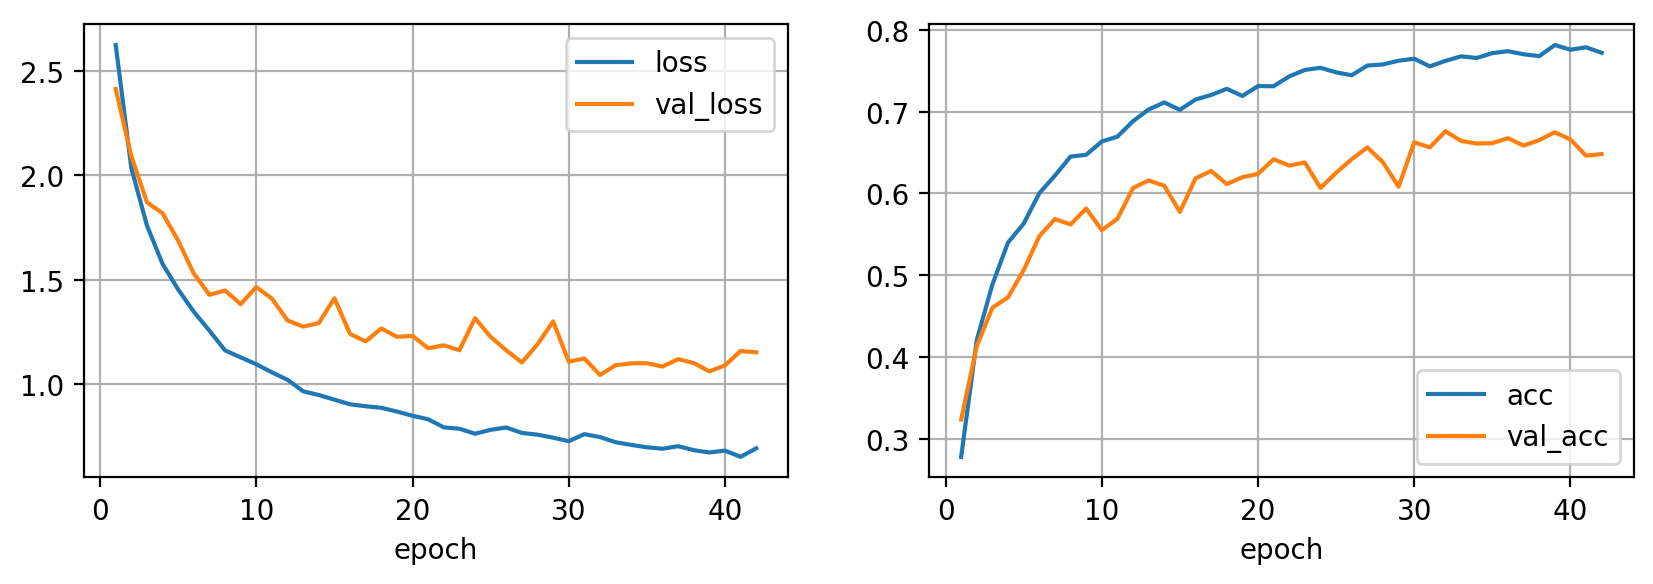

In [ ]:
import pandas as pd 

fig = plt.figure(dpi=200, figsize=(10,3))
ax = plt.subplot(121)
pd.DataFrame(hist).plot(x='epoch', y=['loss', 'val_loss'], grid=True, ax=ax)
ax = plt.subplot(122)
pd.DataFrame(hist).plot(x='epoch', y=['acc', 'val_acc'], grid=True, ax=ax)
plt.show()

Puedes usar tu subset para experimentar rápidamente diferentes combinaciones de transformaciones para encontrar la mejor para tu caso en particular (aunque la opción por defecto es utilizar cuántas más, mejor).

## Tuneado de Hyperparámetros

Una vez hemos elegido unos buenos valores iniciales, tenemos que empezar a explorar el espacio de hyperparámetros de nuestro problema para escoger la mejor combinación. Para ello tenemos dos opciones: grid search o random search. En el primer caso, definiremos todas las posibles combinaciones que queremos probar y las probaremos todas. Como puedes imaginar esto puede ser muy costoso y potencialmente ineficiente. La segunda opción es más recomendada, y consiste en definir un espacio de búsqueda y ejecutar un número determinado de entrenamientos, para cada cual escogeremos un conjunto de hiperparámetros aleatorios del espacio de búsqueda.

In [ ]:
# ejemplo de random search

bss = [16, 32, 64, 128, 256]
lrs = [0.01, 0.005, 0.001, 0.0003, 0.0001]
n = 5
hists = []
for i in range(n):
    lr = random.choice(lrs)
    bs = random.choice(bss)
    print(f"Test {i+1} lr {lr} bs {bs}")
    dataloader = {
        'train': torch.utils.data.DataLoader(dataset['train'], batch_size=bs, shuffle=True),
        'val': torch.utils.data.DataLoader(dataset['val'], batch_size=1000, shuffle=False)
    }
    model = build_model()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    hist = fit(model, dataloader, optimizer, epochs=20, verbose=0)
    hists.append({'hist': hist, 'lr': lr, 'bs': bs})

Test 1 lr 0.005 bs 128
Test 2 lr 0.001 bs 128
Test 3 lr 0.0003 bs 256
Test 4 lr 0.0003 bs 64
Test 5 lr 0.0003 bs 32


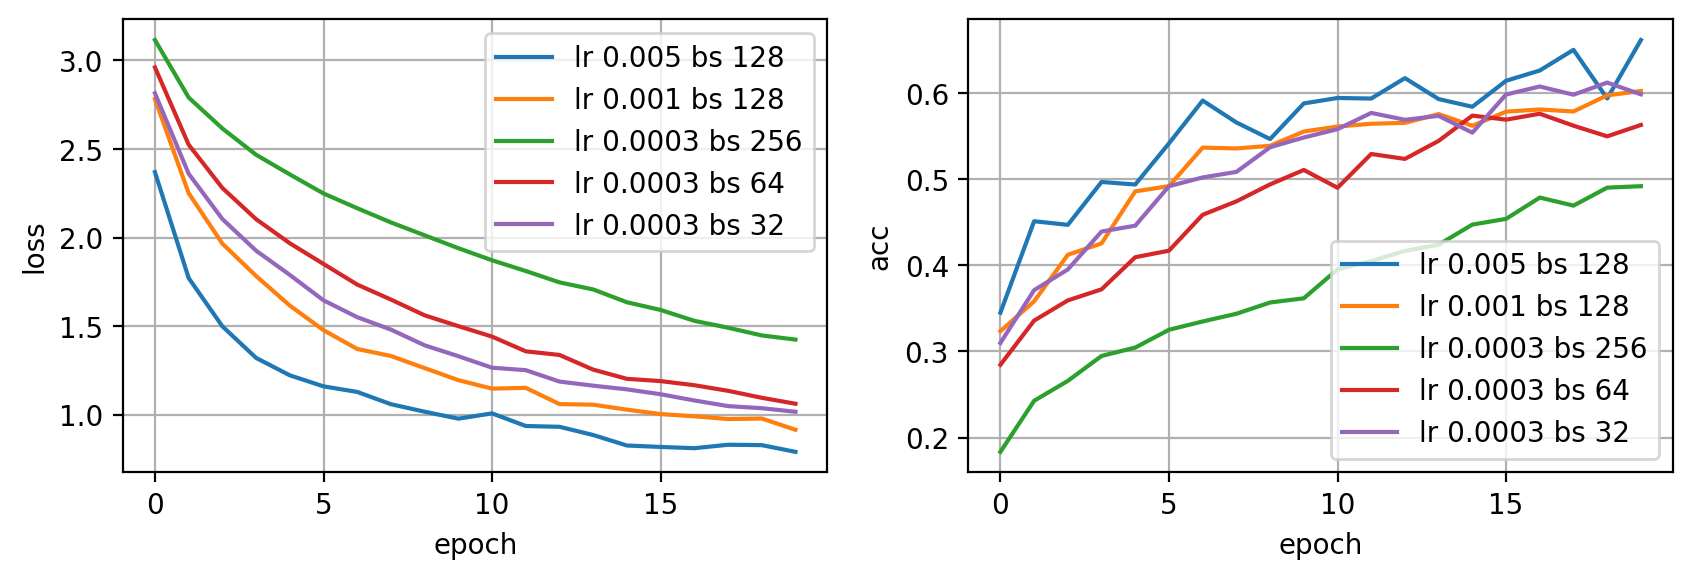

In [ ]:
fig = plt.figure(dpi=200, figsize=(10,3))
ax = plt.subplot(121)
for i in range(len(hists)):
    ax.plot(hists[i]['hist']['loss'], label=f'lr {hists[i]["lr"]} bs {hists[i]["bs"]}')
ax.legend()
ax.grid(True)
ax.set_xlabel('epoch')
ax.set_ylabel('loss')
ax = plt.subplot(122)
for i in range(len(hists)):
    ax.plot(hists[i]['hist']['val_acc'], label=f'lr {hists[i]["lr"]} bs {hists[i]["bs"]}')
ax.legend()
ax.grid(True)
ax.set_ylabel('acc')
ax.set_xlabel('epoch')
plt.show()

## Últimos toques

Y ya para terminar, puedes experimentar con varios schedulers que vayan modificando el learning rate durante el entrenamiento. Esta técnica es especialmente interesante en combinación con transfer learning.

In [ ]:
model = build_model()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 20, 0.1)
hist = fit(model, dataloader, optimizer, scheduler, epochs=100, early_stopping=10, verbose=2)

Mejor modelo guardado con acc 0.31465 en epoch 1
Epoch 1/100 loss 2.52383 acc 0.28264 val_loss 2.32943 val_acc 0.31465 lr 0.00100
Mejor modelo guardado con acc 0.39402 en epoch 2
Epoch 2/100 loss 1.97092 acc 0.42556 val_loss 2.04721 val_acc 0.39402 lr 0.00100
Mejor modelo guardado con acc 0.45125 en epoch 3
Epoch 3/100 loss 1.70190 acc 0.50060 val_loss 1.85153 val_acc 0.45125 lr 0.00100
Mejor modelo guardado con acc 0.49581 en epoch 4
Epoch 4/100 loss 1.52881 acc 0.54140 val_loss 1.67674 val_acc 0.49581 lr 0.00100
Epoch 5/100 loss 1.39191 acc 0.57703 val_loss 1.64831 val_acc 0.49380 lr 0.00100
Mejor modelo guardado con acc 0.54763 en epoch 6
Epoch 6/100 loss 1.30183 acc 0.60430 val_loss 1.47875 val_acc 0.54763 lr 0.00100
Mejor modelo guardado con acc 0.55357 en epoch 7
Epoch 7/100 loss 1.23852 acc 0.62221 val_loss 1.49505 val_acc 0.55357 lr 0.00100
Mejor modelo guardado con acc 0.58438 en epoch 8
Epoch 8/100 loss 1.17153 acc 0.63416 val_loss 1.36674 val_acc 0.58438 lr 0.00100
Epoch 9/1

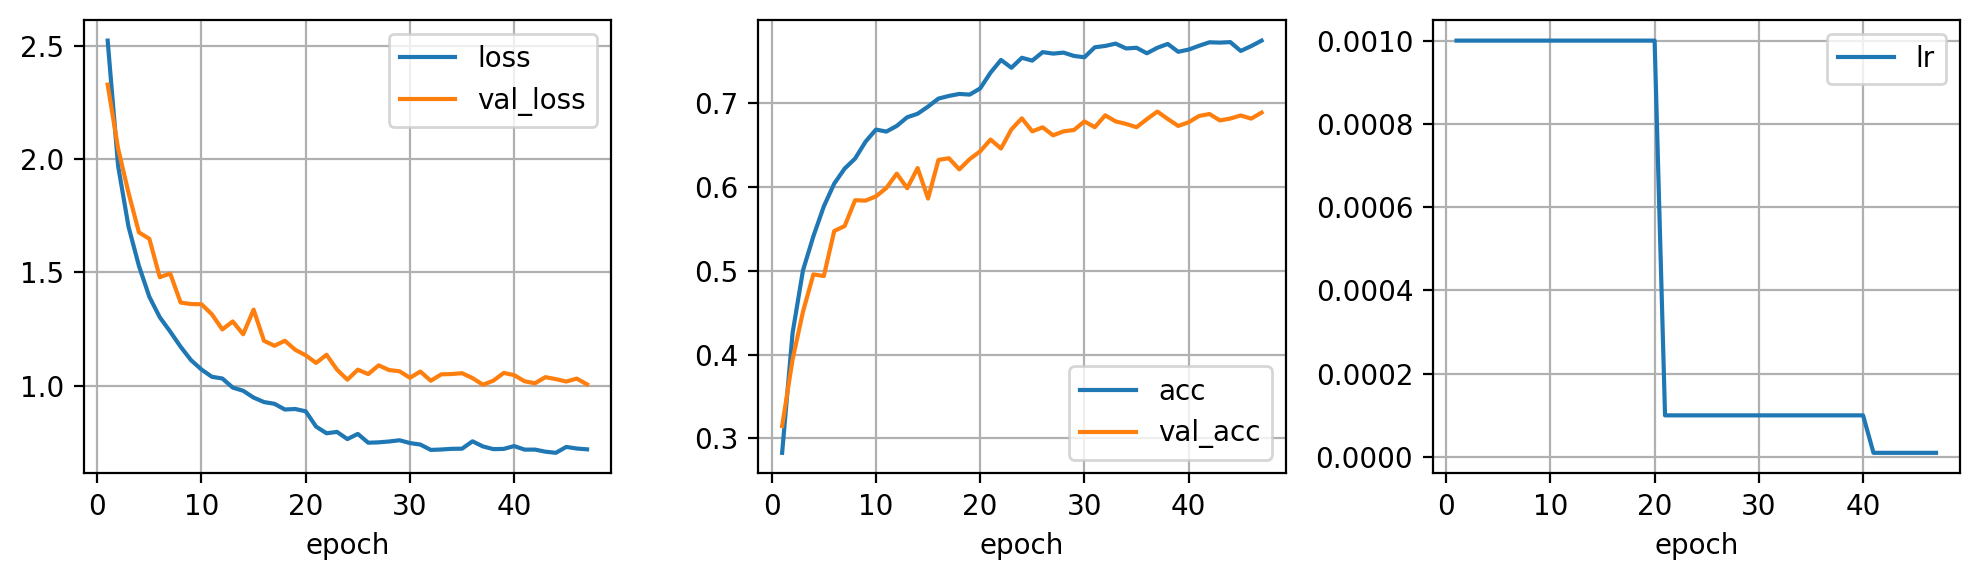

In [ ]:
fig = plt.figure(dpi=200, figsize=(10,3))
ax = plt.subplot(131)
pd.DataFrame(hist).plot(x='epoch', y=['loss', 'val_loss'], grid=True, ax=ax)
ax = plt.subplot(132)
pd.DataFrame(hist).plot(x='epoch', y=['acc', 'val_acc'], grid=True, ax=ax)
ax = plt.subplot(133)
pd.DataFrame(hist).plot(x='epoch', y=['lr'], grid=True, ax=ax)
plt.tight_layout()
plt.show()

Y, por supuesto, utilizar todos los datos una vez hayas encontrado una buena combinación de hyperparámetros en tu subset.

In [ ]:
dataset = {
    'train': Dataset(X_train, y_train, trans=trans),
    'val': Dataset(X_val, y_val),
}

dataloader = {
    'train': torch.utils.data.DataLoader(dataset['train'], batch_size=64, shuffle=True),
    'val': torch.utils.data.DataLoader(dataset['val'], batch_size=1000, shuffle=False)
}

len(dataset['train']), len(dataset['val'])

(40000, 84800)

In [ ]:
model = build_model()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 20, 0.1)
hist = fit(model, dataloader, optimizer, scheduler, epochs=100, early_stopping=10, verbose=2)



Mejor modelo guardado con acc 0.61385 en epoch 1
Epoch 1/100 loss 1.66527 acc 0.51800 val_loss 1.28140 val_acc 0.61385 lr 0.00100
Mejor modelo guardado con acc 0.65859 en epoch 2
Epoch 2/100 loss 1.02136 acc 0.68330 val_loss 1.10053 val_acc 0.65859 lr 0.00100
Epoch 3/100 loss 0.89335 acc 0.71593 val_loss 1.11013 val_acc 0.64694 lr 0.00100
Epoch 4/100 loss 0.80919 acc 0.74265 val_loss 1.09264 val_acc 0.65472 lr 0.00100
Mejor modelo guardado con acc 0.69990 en epoch 5
Epoch 5/100 loss 0.76268 acc 0.75775 val_loss 0.94025 val_acc 0.69990 lr 0.00100
Mejor modelo guardado con acc 0.70265 en epoch 6
Epoch 6/100 loss 0.72837 acc 0.76520 val_loss 0.93401 val_acc 0.70265 lr 0.00100
Epoch 7/100 loss 0.69841 acc 0.77380 val_loss 0.99818 val_acc 0.68077 lr 0.00100
Mejor modelo guardado con acc 0.71814 en epoch 8
Epoch 8/100 loss 0.68039 acc 0.77982 val_loss 0.89668 val_acc 0.71814 lr 0.00100
Mejor modelo guardado con acc 0.72965 en epoch 9
Epoch 9/100 loss 0.66607 acc 0.78448 val_loss 0.84431 val_

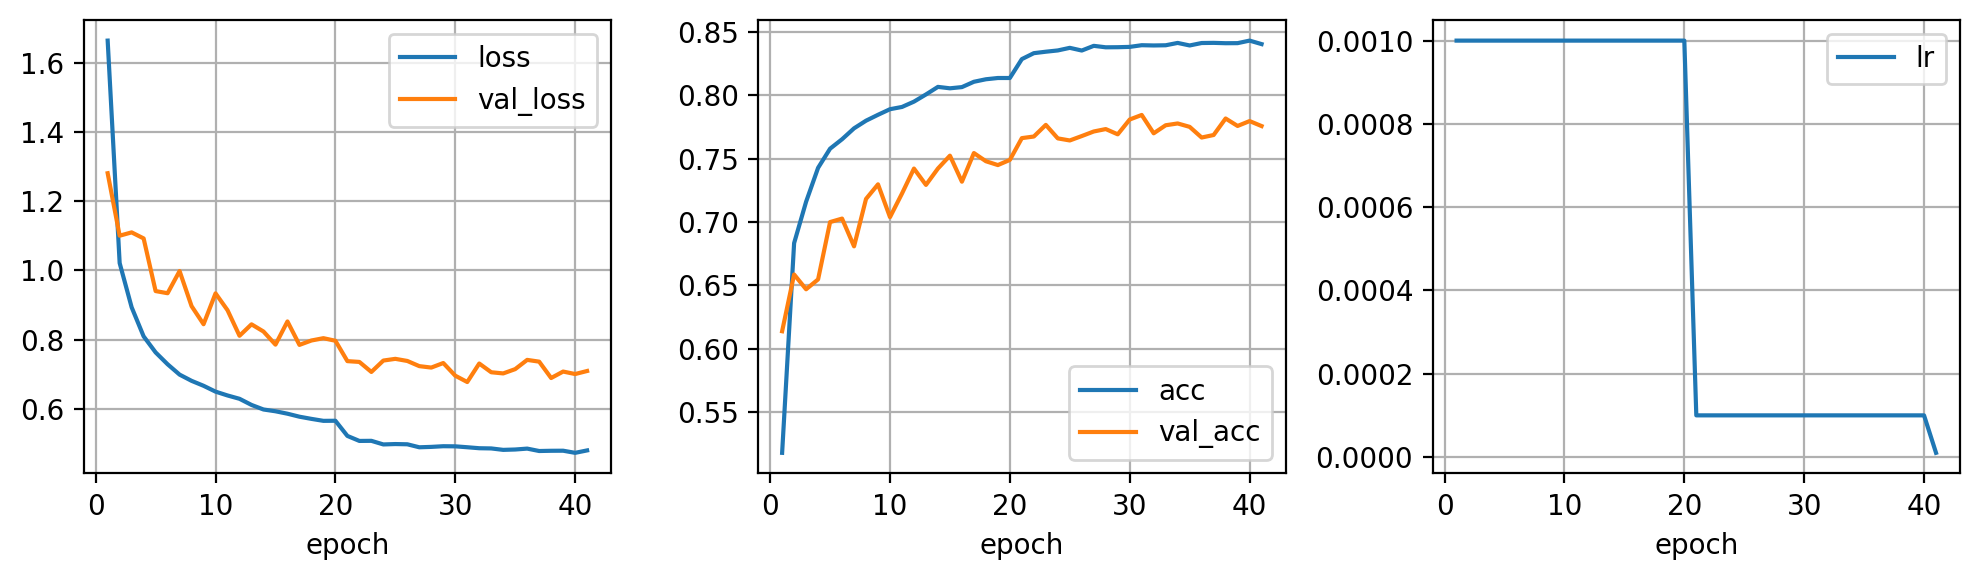

In [ ]:
fig = plt.figure(dpi=200, figsize=(10,3))
ax = plt.subplot(131)
pd.DataFrame(hist).plot(x='epoch', y=['loss', 'val_loss'], grid=True, ax=ax)
ax = plt.subplot(132)
pd.DataFrame(hist).plot(x='epoch', y=['acc', 'val_acc'], grid=True, ax=ax)
ax = plt.subplot(133)
pd.DataFrame(hist).plot(x='epoch', y=['lr'], grid=True, ax=ax)
plt.tight_layout()
plt.show()

# Conclusión
Se observa que el mejor learnign rate fue de 0.001 comparando con los learning rate de 0.01 y 0.0001, ya que este tiende a bajar el error.
Se puede considerar usar el learnign rate de 0.01 y 0.001 que no habria mucha dorefencia. 
El peor learning rate es el 0.0001. 

# Referencia :
Receta de entrenamiento de Sensio 
[link del video:](https://www.youtube.com/watch?v=5QLGn4sYDJw&list=PLkgbkukKg_NpdJPhhHbemaWHNQCY-lmh1&index=18)
